## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from pathlib import Path
from tqdm.notebook import tqdm



import torchvision.utils
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
%pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


Note: you may need to restart the kernel to use updated packages.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [4]:
import torch
print("CUDA available? ", torch.cuda.is_available())
print("MPS available?  ", torch.backends.mps.is_available())

CUDA available?  False
MPS available?   True


## 3. Prepare Data

In [5]:
from pathlib import Path

ROOT = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent
data_dir = ROOT / "data"
data_dir.mkdir(exist_ok=True)


In [6]:
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer",
                  "dog", "frog", "horse", "ship", "truck"]
class_idx = {
    str(i): [f"cifar10_{label}", label] for i, label in enumerate(cifar10_labels)
}
(data_dir / "cifar10_class_index.json").write_text(json.dumps(class_idx, indent=2))

472

In [7]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
with (ROOT / "data" / "cifar10_class_index.json").open() as fh:
    class_idx = json.load(fh)

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])


In [9]:
def cifar10_with_custom_labels(root, transform, custom_label, train=False):
    dataset = dsets.CIFAR10(root=root, train=train, download=True, transform=transform)
    dataset.classes = custom_label
    dataset.class_to_idx = {label: idx for idx, label in enumerate(custom_label)}
    return dataset


In [10]:
# CIFAR-10 loader (test split)
normal_data = cifar10_with_custom_labels(
    root=ROOT / ".data",    # same ROOT you set earlier
    transform=transform,
    custom_label=idx2label,
    train=False,
)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)


In [11]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


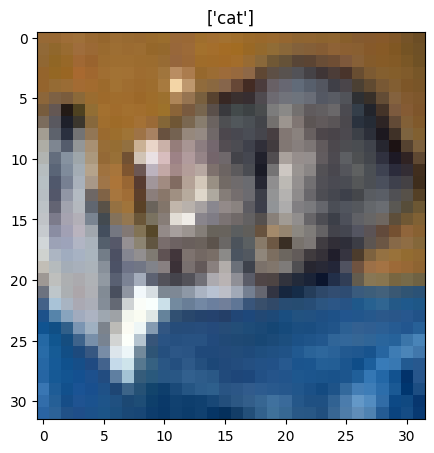

In [12]:
normal_iter = iter(normal_loader)
images, labels = next(normal_iter)

print("True Image & True Label")
imshow(
    torchvision.utils.make_grid(images, normalize=True),
    [normal_data.classes[i] for i in labels],
)


## 4. Download the ResNet-18

In [13]:
ROOT = Path.cwd() if (Path.cwd() / "model_best.pth.tar").exists() else Path.cwd().parent

def build_cifar_resnet18(num_classes=10):
    model = models.resnet18(weights=None)
    # thay conv1 7x7 stride2 -> 3x3 stride1, và bỏ maxpool để giữ kích thước feature map phù hợp
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def load_checkpoint(model, ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location="cpu")
    missing, unexpected = model.load_state_dict(checkpoint["state_dict"], strict=False)
    if missing or unexpected:
        raise RuntimeError(f"Checkpoint mismatch: missing {missing}, unexpected {unexpected}")
    return model

device = torch.device("mps" if torch.mps.is_available() else "mps" if torch.mps.is_available()  else "cpu")
print(f"Device use to train:", device)
model = build_cifar_resnet18().to(device)
model = load_checkpoint(model, ROOT / "model_best.pth.tar")
model.to(device).eval()

Device use to train: mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [14]:
MEAN = torch.tensor([0.4914, 0.4822, 0.4465], device=device).view(1, 3, 1, 1) 
STD = torch.tensor([0.2470, 0.2435, 0.2616], device=device).view(1, 3, 1, 1)

# Clean Accuracy

True Image & Predicted Label


Clean Accuracy:   0%|          | 0/10000 [00:00<?, ?it/s]

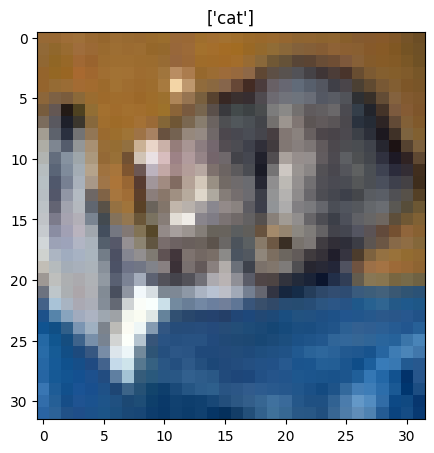

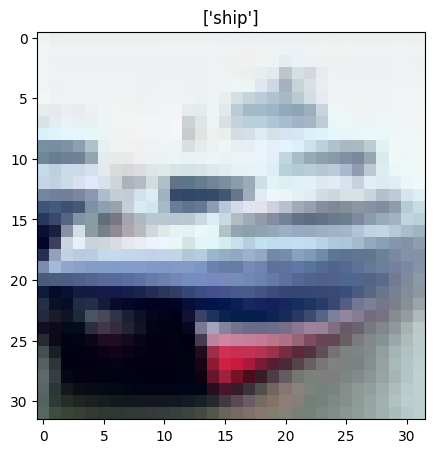

Number of images:  10000
Accuracy of test text:  92.05


In [16]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0


for idx, (images, labels) in enumerate(
        tqdm(normal_loader, total=len(normal_loader), desc="Clean Accuracy"),
        start=1,
):    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, preds = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (preds == labels).sum()

    if idx < 3:
        imshow(
            torchvision.utils.make_grid(images.cpu(), normalize=True),
            [normal_data.classes[i] for i in preds],
        )
dataset_size = len(normal_loader.dataset) 
print(f"Number of images: ", dataset_size)
clean_accuracy=(100 * float(correct) / total)
print(f"Accuracy of test text: ", clean_accuracy)

## 5. Adversarial Attack

$$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$$
* $S$ : a set of allowed perturbations

In [ ]:
# CIFAR-10 constants used in your transform
# reshapes to broadcast over NCHW - number, channel, height, width batches: (N,3,H,W).

def pgd_attack(model, images, labels, eps=8/255, alpha=2/255, iters=40):
    """
        Projected Gradient Descent (L∞) in **normalized space**.

        This routine performs an untargeted PGD attack by taking sign-gradient
        steps on the **normalized** inputs, projecting after each step onto the
        L∞ ball of radius `eps / STD` (per channel) around the original normalized
        image, and clipping to the valid normalized bounds that map to pixel [0,1].

        Parameters
        ----------
        model : nn.Module
            Model that expects normalized inputs; should be in `eval()` mode.
        images : torch.Tensor
            Normalized batch of shape (N, C, H, W), where `images = (x - MEAN) / STD`.
        labels : torch.Tensor
            Ground-truth class indices of shape (N,).
        eps : float, optional
            L∞ budget in pixel units (e.g., 8/255). Internally converted to normalized units by dividing by `STD`.
        alpha : float, optional
            Step size per iteration in pixel units (e.g., 2/255). Internally converted to normalized units by dividing by `STD`.
        iters : int, optional
            Number of PGD iterations.

        Returns
        -------
        torch.Tensor
            Adversarial images in **normalized space** (same shape/device as `images`).

        Notes
        -----
        - This is the **untargeted** variant (maximizes CE on the true labels).
        - Projection and clipping are in normalized space with bounds:
        `z_min = (0 - MEAN) / STD` and `z_max = (1 - MEAN) / STD`.

    """
    # put batches on device
    images = images.to(device)
    labels = labels.to(device)
    
    # create loss CE
    loss = nn.CrossEntropyLoss()

    # scale eps/alpha to normalized space
    # So a pixel-space change Δx maps to normalized change Δz = Δx/STD.
    # Do this per channel (hence tensors), so steps/budgets are correct after normalization
 

    # Save the anchor z₀ to project around.
    # .detach() ensures no gradient history is kept for the anchor.
    ori_images = images.clone().detach()

    # Repeat gradient steps + projection.
    for _ in range(iters):
        # Tell autograd to track gradients w.r.t. the current adversarial image images.
        images.requires_grad = True
        # Forward pass (model expects normalized inputs).
        outputs = model(images)

        # Clear parameter grads; backprop CE to get ∂L/∂images.
        # (You’re not updating model params here; zeroing is harmless/clean.)
        model.zero_grad()
        loss(outputs, labels).backward()

        # L∞ steepest-ascent direction: elementwise sign of the gradient.
        grad_sign = images.grad.sign()

        # Take one ascent step in normalized space (scaled per channel).
        adv_images = images + alpha_norm * grad_sign

        # Compute perturbation wrt the anchor: η = z - z₀.
        # Project η back to the L∞ ball of radius eps_norm (per-channel).
        eta = torch.clamp(adv_images - ori_images, min=-eps_norm, max=eps_norm)

        # clamp to normalized range
        # Recompose z = z₀ + η.
        # Clip to valid normalized range corresponding to pixel [0,1]:
	    # pixel 0 → normalized (-MEAN)/STD
	    # pixel 1 → normalized (1 - MEAN)/STD
	    # .detach() breaks the graph so the next loop starts fresh (so images.grad won’t accumulate).
        images = torch.clamp(ori_images + eta,
                             min=(-MEAN) / STD,
                             max=(1 - MEAN) / STD).detach()
    return images

def cw_attack():
    pass

def df_attack():
    pass


Attack Image & Predicted Label on first 3


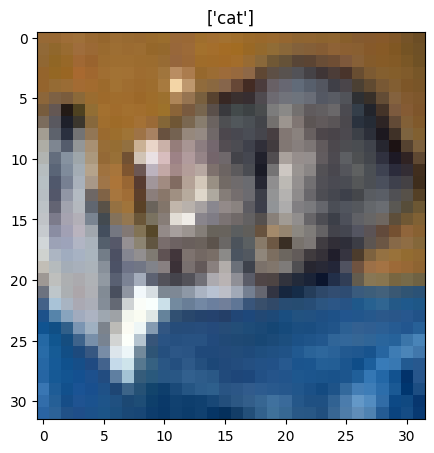

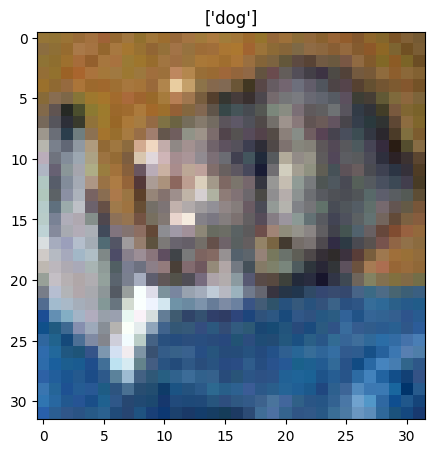

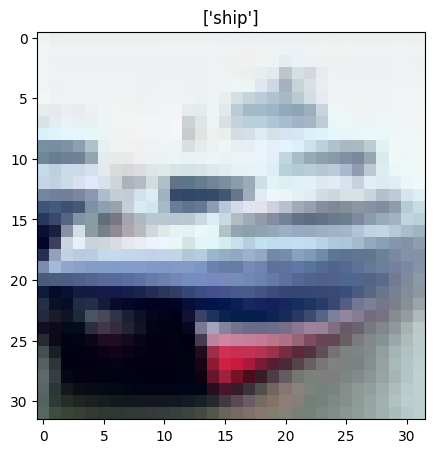

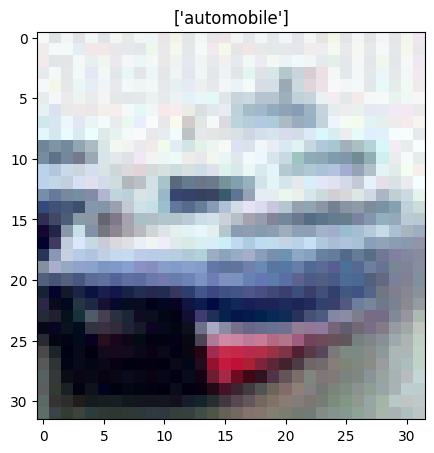

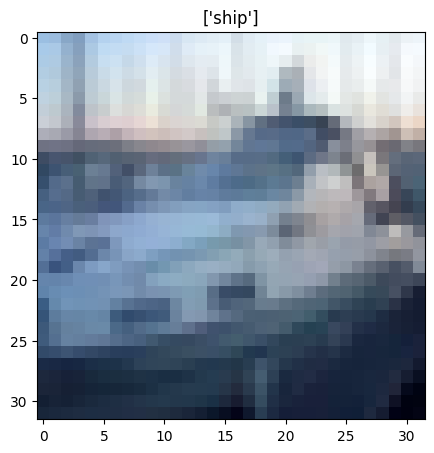

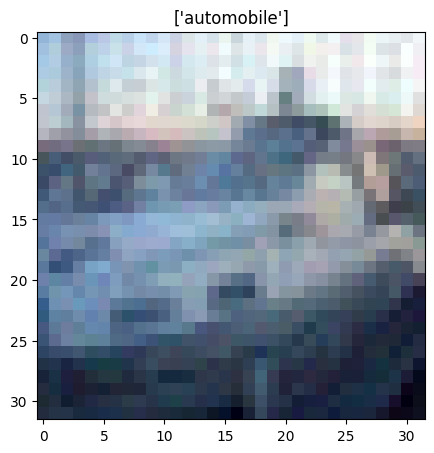

Adversarial accuracy on first 3: 0.00%


In [18]:
print("Attack Image & Predicted Label on first 3")

model.eval()
correct = 0
total = 0

for idx, (clean, labels) in enumerate(normal_loader):
    if idx >= 3:
        break

    adv = pgd_attack(model, clean, labels)

    with torch.no_grad():
        clean_logits = model(clean.to(device))
        adv_logits = model(adv.to(device))

    clean_pred = clean_logits.argmax(1).cpu()
    adv_pred = adv_logits.argmax(1).cpu()
    labels = labels.cpu()

    total += labels.size(0)
    correct += (adv_pred == labels).sum()

    # show them one pair at a time
    imshow(
        torchvision.utils.make_grid(clean.cpu(), normalize=True),
        [normal_data.classes[i] for i in clean_pred],
    )
    imshow(
        torchvision.utils.make_grid(adv.cpu(), normalize=True),
        [normal_data.classes[i] for i in adv_pred],
    )

print(f"Adversarial accuracy on first 3: {100 * float(correct) / total:.2f}%")


# Generate attack batches

## PGD Attack

In [ ]:
attack = pgd_attack                   # swap this line to cw_attack, fgsm_attack, …

attack_name = attack.__name__         # e.g. "pgd_attack"
adv_var = f"adv_images_{attack_name}" # "adv_images_pgd_attack"
label_var = f"adv_labels_{attack_name}"
path = ROOT / "assets" / f"{attack_name}.pt"

# generate samples as before
adv_batches, label_batches = [], []
model.eval()
for idx, (images, labels) in enumerate(tqdm(normal_loader, total=len(normal_loader), desc=f"{attack_name} generation")):
    # if idx >= 10: break
    adv = attack(model, images.to(device), labels.to(device))
    adv_batches.append(adv.detach().cpu())
    label_batches.append(labels.cpu())

globals()[adv_var] = torch.cat(adv_batches)
globals()[label_var] = torch.cat(label_batches)

torch.save({ "images": globals()[adv_var], "labels": globals()[label_var] }, path)
print(f"Saved {attack_name} cache to {path}")


In [ ]:
attack_tag = attack.__name__.replace("_attack", "")   # → "pgd"

# reuse the tag for cached tensors (assuming you generated them earlier)
adv_images = torch.cat(adv_batches)
adv_labels = torch.cat(label_batches)

# loader
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(
    adv_dataset,
    batch_size=normal_loader.batch_size,
    shuffle=False,
)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for idx, (adv, labels) in enumerate(
        tqdm(adv_loader, total=len(adv_loader), desc=f"{attack_tag.upper()} eval"),
        start=1,
    ):
        adv = adv.to(device)
        labels = labels.to(device)
        preds = model(adv).argmax(1)

        total += labels.size(0)
        correct += (preds == labels).sum()

        if idx <= 3:   # peek at first 3 batches
            imshow(
                torchvision.utils.make_grid(adv.cpu(), normalize=True),
                [normal_data.classes[i] for i in preds.cpu()],
            )

adv_accuracy = 100 * float(correct) / total
print(f"{attack_tag.upper()} adversarial accuracy: {adv_accuracy:.2f}% ({correct}/{total})")


In [36]:
# generate samples as before
adv_batches, label_batches = [], []
model.eval()
for idx, (images, labels) in enumerate(tqdm(normal_loader, total=len(normal_loader), desc=f"{attack_name} generation")):
    # if idx >= 10: break
    adv = attack(model, images.to(device), labels.to(device))
    adv_batches.append(adv.detach().cpu())
    label_batches.append(labels.cpu())

globals()[adv_var] = torch.cat(adv_batches)
globals()[label_var] = torch.cat(label_batches)

torch.save({ "images": globals()[adv_var], "labels": globals()[label_var] }, path)
print(f"Saved {attack_name} cache to {path}")


pgd_attack generation:   0%|          | 0/10000 [00:00<?, ?it/s]

Saved pgd_attack cache to /Users/kiet-na/Documents/Github/adversarial-dg/assets/pgd_attack.pt


PGD eval:   0%|          | 0/10000 [00:00<?, ?it/s]

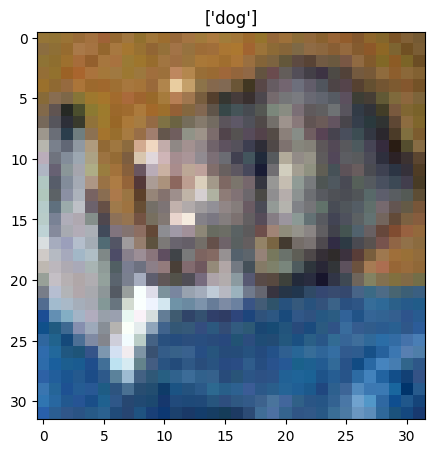

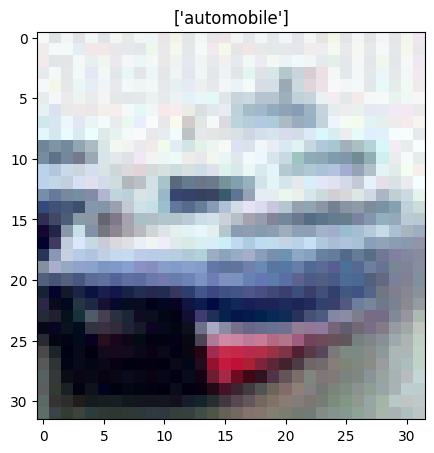

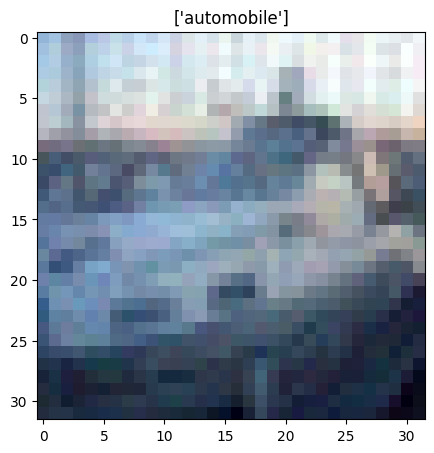

PGD adversarial accuracy: 0.00% (0/10000)


In [38]:
attack = pgd_attack          # later, set this to cw_attack, fgsm_attack, …
attack_tag = attack.__name__.replace("_attack", "")   # → "pgd"

# reuse the tag for cached tensors (assuming you generated them earlier)
adv_images = torch.cat(adv_batches)
adv_labels = torch.cat(label_batches)

# loader
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(
    adv_dataset,
    batch_size=normal_loader.batch_size,
    shuffle=False,
)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for idx, (adv, labels) in enumerate(
        tqdm(adv_loader, total=len(adv_loader), desc=f"{attack_tag.upper()} eval"),
        start=1,
    ):
        adv = adv.to(device)
        labels = labels.to(device)
        preds = model(adv).argmax(1)

        total += labels.size(0)
        correct += (preds == labels).sum()

        if idx <= 3:   # peek at first 3 batches
            imshow(
                torchvision.utils.make_grid(adv.cpu(), normalize=True),
                [normal_data.classes[i] for i in preds.cpu()],
            )

adv_accuracy = 100 * float(correct) / total
print(f"{attack_tag.upper()} adversarial accuracy: {adv_accuracy:.2f}% ({correct}/{total})")
